In [1]:
import importlib
import funciones_analisis.estadisticas

importlib.reload(funciones_analisis.estadisticas)
importlib.reload(funciones_analisis.generales)

from funciones_analisis.estadisticas import *
from funciones_analisis.generales import *
from statsbombpy import sb
import pandas as pd
from mplsoccer import VerticalPitch, Pitch
from highlight_text import ax_text, fig_text
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects
import seaborn as sns
import glob
from mplsoccer import Radar
import numpy as np

In [2]:
free_comps = sb.competitions()

free_comps[free_comps["competition_name"] == "Women's World Cup"]


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
72,72,107,International,Women's World Cup,female,False,True,2023,2024-07-14T16:59:48.469596,2024-07-14T17:01:38.887279,2024-07-14T17:01:38.887279,2024-07-14T16:59:48.469596
73,72,30,International,Women's World Cup,female,False,True,2019,2024-02-13T09:41:26.379767,2021-06-13T16:17:31.694,None,2024-02-13T09:41:26.379767


In [3]:
# Extraer únicos con país y si es internacional
df_unique = free_comps[['competition_name', 'country_name']].drop_duplicates()

# Ordenar por nombre
df_unique = df_unique.sort_values('competition_name')

# Guardar resultado
#df_unique.to_csv("datos/otros/competitions_with_country.csv", index=False)


In [4]:
!pip install pillow


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
from PIL import Image
import os

# Ruta a la carpeta de imágenes
carpeta = "imagenes/competiciones_statsbomb"

# Parámetros
max_ancho, max_alto = 180, 180
espaciado = 30
layout = [3, 5, 5, 5, 3]  # Distribución por fila

# Cargar y escalar imágenes proporcionalmente
imagenes = []
for archivo in sorted(os.listdir(carpeta)):
    if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
        ruta = os.path.join(carpeta, archivo)
        img = Image.open(ruta).convert("RGBA")
        img.thumbnail((max_ancho, max_alto), Image.LANCZOS)
        imagenes.append(img)

# Comprobamos que tenemos el número correcto de imágenes
total_necesario = sum(layout)
if len(imagenes) != total_necesario:
    raise ValueError(f"Se esperaban {total_necesario} imágenes, pero hay {len(imagenes)}.")

# Calcular dimensiones del collage
ancho_max = max(layout) * max_ancho + (max(layout) + 1) * espaciado
alto_total = len(layout) * max_alto + (len(layout) + 1) * espaciado

# Crear lienzo blanco
collage = Image.new("RGBA", (ancho_max, alto_total), (255, 255, 255, 255))

# Pegar imágenes según layout
indice = 0
for fila_idx, num_col in enumerate(layout):
    y = espaciado + fila_idx * (max_alto + espaciado)

    # Calcular margen izquierdo para centrar
    fila_ancho = num_col * max_ancho + (num_col - 1) * espaciado
    margen_izq = (ancho_max - fila_ancho) // 2

    for col in range(num_col):
        img = imagenes[indice]
        x = margen_izq + col * (max_ancho + espaciado)

        # Centrar dentro del recuadro
        x_offset = x + (max_ancho - img.width) // 2
        y_offset = y + (max_alto - img.height) // 2

        collage.paste(img, (x_offset, y_offset), img)
        indice += 1

# Guardar collage final
#collage.save("imagenes/collage_distribucion_personalizada.png")
print("✅ Collage guardado como collage_distribucion_personalizada.png")


✅ Collage guardado como collage_distribucion_personalizada.png


In [8]:
# Cargar datos
df_centrales = pd.read_csv("datos/normalizaciones_posicion/percentiles/centrales_percentil.csv")

In [9]:
# Selección de métricas clave
estadisticas = [
    'tackle_success_rate',
    'interceptions_per90',
    'clearances_per90',
    'blocks_per90',
    'duels_won_per90',
    'times_dribbled_past_per90',
    'progressive_passes_per90',
    'duel_success_rate'
]


In [10]:
# Títulos amigables
labels = [
    'Tackle %',
    'Intercepciones /90',
    'Despejes /90',
    'Bloqueos /90',
    'Duelos ganados /90',
    'Regates sufridos /90',
    'Pases progresivos /90',
    'Éxito en duelos %'
]

In [11]:
# Rango de percentiles
low = np.zeros(len(estadisticas))
high = np.ones(len(estadisticas)) * 100

AttributeError: 'Radar' object has no attribute 'draw_circular'

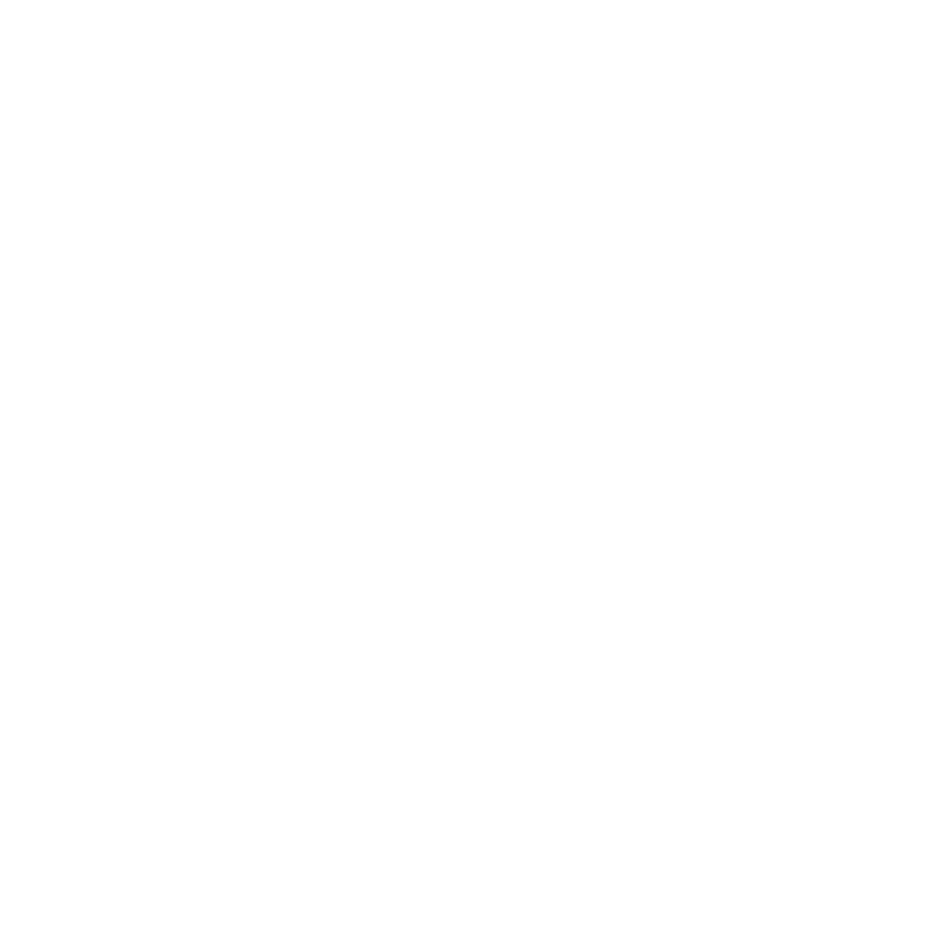

In [12]:
# Radar con todos los valores como flotantes (no redondear)
radar = Radar(
    params=labels,
    min_range=low,
    max_range=high,
    round_int=[False] * len(labels),  # <== CORRECCIÓN
    num_rings=4,
    ring_width=1,
    center_circle_radius=1
)

# Crear gráfico
fig, ax = radar.setup_axis()
radar.draw_circular(ax=ax, facecolor='white', edgecolor='black')
radar.draw_radar(values=valores, ax=ax,
                 kwargs_radar={'facecolor': '#1f77b4', 'alpha': 0.6},
                 kwargs_outline={'linewidth': 2, 'color': '#1f77b4'})